<a href="https://colab.research.google.com/github/anna-marshalova/fall-detection/blob/main/fall_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
ROOT = '/content/'

#Downloading Data

In [ ]:
!pip install roboflow

In [ ]:
import json
KEY_PATH = os.path.join(ROOT, 'roboflow_api_key.json')
with open(KEY_PATH) as key_json:
    roboflow_api_key = json.load(key_json)['key']

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key=roboflow_api_key)
project = rf.workspace("roboflow-universe-projects").project("fall-detection-ca3o8")
dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to Fall-Detection-1 in yolov5pytorch:: 100%|██████████| 9006/9006 [00:03<00:00, 2609.58it/s]


#Preprocessing Data

In [ ]:
DATA_DIR = os.path.join(ROOT, 'Fall-Detection-1')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'valid')
TEST_DIR = os.path.join(DATA_DIR, 'test')

In [ ]:
import torch
from torch.utils.data import Dataset
import os
import pandas as pd
import cv2

class DetectionDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.images_dir = os.path.join(self.data_dir, 'images')
        self.labels_dir = os.path.join(self.data_dir, 'labels')
        self.image_ids = sorted([fname.replace('.jpg', '') for fname in os.listdir(self.images_dir)])

    def get_coordinates(self, labels):
        max_area = 0
        for label in labels:
            coordinates = [float(c) for c in label.strip().split()[1:]]
            width, height = coordinates[2:]
            area = abs(width * height)
            if area > max_area:
                max_coordinates = coordinates
        return np.array(max_coordinates)


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.images_dir, f'{image_id}.jpg')
        label_path = os.path.join(self.labels_dir, f'{image_id}.txt')
        image = cv2.imread(image_path)
        with open(label_path) as label_file:
            labels = label_file.readlines()
            coordinates = self.get_coordinates(labels)
        sample = {'image': image, 'label':coordinates}

        return sample

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def display(sample, **kwargs):
    image, yolo_coordinates = sample.values()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_height, img_width = image.shape[:2]
    scale = [img_width, img_height, img_width, img_height]
    yolo_coordinates_norm = np.array(yolo_coordinates)
    yolo_coordinates_abs = (yolo_coordinates_norm * scale).astype(int)
    image = add_bbox(image, yolo_coordinates_abs, **kwargs)
    plt.imshow(image)

def add_bbox(image, yolo_coordinates_abs, border_color = [255, 0, 0]):
    x_center, y_center, bbox_width, bbox_height = yolo_coordinates_abs
    left, right = x_center - bbox_width//2, x_center + bbox_width//2
    bottom, top = y_center - bbox_height//2, y_center + bbox_height//2
    image[top, left:right, :] = border_color
    image[bottom, left:right, :] = border_color
    image[bottom:top, left, :] = border_color
    image[bottom:top, right, :] = border_color
    return image

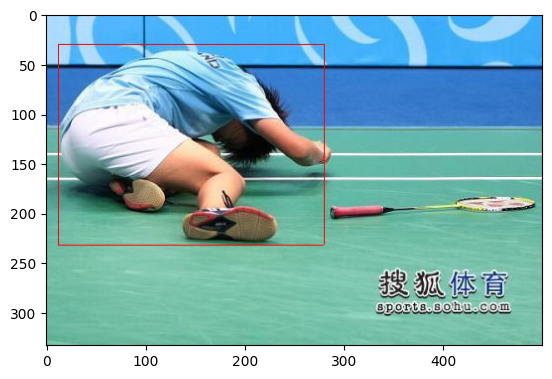

In [ ]:
import random
train_dataset = DetectionDataset(TRAIN_DIR)
i = random.randint(0, len(train_dataset))
display(train_dataset[i])